**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

Data from the datbase, but from the old bucket `CH-CHA_processing`.

# **Auto-settings**

## Data settings

In [11]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [12]:
import importlib.metadata
from datetime import datetime

%matplotlib inline
import seaborn as sns
from pathlib import Path
from diive.core.io.files import save_parquet

sns.set_theme('notebook')
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.80.0
dbc-influxdb version: v0.12.0
Reading configuration files was successful.
Connection to database works.


</br>

# **DOWNLOAD** screened data from the database

In [17]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['TA', 'SW', 'PPFD', 'LW', 'RH', 'PA'],
    fields=[
        'TA_T1_2_1',
        'SW_IN_T1_2_1',
        'PPFD_IN_T1_2_2',
        'LW_IN_T1_2_1',
        'RH_T1_2_1',
        'PA_GF1_0.9_1'
    ],
    start='2021-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2024-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='meteoscreening_diive'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['TA_T1_2_1', 'SW_IN_T1_2_1', 'PPFD_IN_T1_2_2', 'LW_IN_T1_2_1', 'RH_T1_2_1', 'PA_GF1_0.9_1']
    from measurements ['TA', 'SW', 'PPFD', 'LW', 'RH', 'PA']
    from data version meteoscreening_diive
    between 2021-01-01 00:00:01 and 2024-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2024-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "SW" or r["_measurement"] == "PPFD" or r["_measurement"] == "LW" or r["_measurement"] == "RH" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_2_1" or r["_field"] == "SW_IN_T1_2_1" or r["_field"] == "PPFD_IN_T1_2_2" or r["_field"] == "LW_IN_T1_2_1" or r["_field"] == "RH_T1_2_1" or r["_field"] == "PA_GF1_0.9_1") |> pivot(rowKey:["_time"], columnKey: ["_field"],

In [18]:
data_simple

,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_END,,,,,,
2021-01-01 00:30:00,332.179450,958.107523,0.0,100.000000,0.0,0.156080
2021-01-01 01:00:00,329.543557,958.088840,0.0,100.000000,0.0,0.102816
2021-01-01 01:30:00,328.928400,958.323920,0.0,100.000000,0.0,0.105138
2021-01-01 02:00:00,331.492063,958.425240,0.0,99.998978,0.0,0.168548
2021-01-01 02:30:00,332.917923,958.625800,0.0,99.999973,0.0,0.214706
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407107,964.969617,0.0,99.461884,0.0,1.540578
2023-12-31 22:30:00,327.958383,965.049553,0.0,98.875075,0.0,2.051889
2023-12-31 23:00:00,328.605910,965.261047,0.0,97.569925,0.0,2.223067


## Plot downloaded data

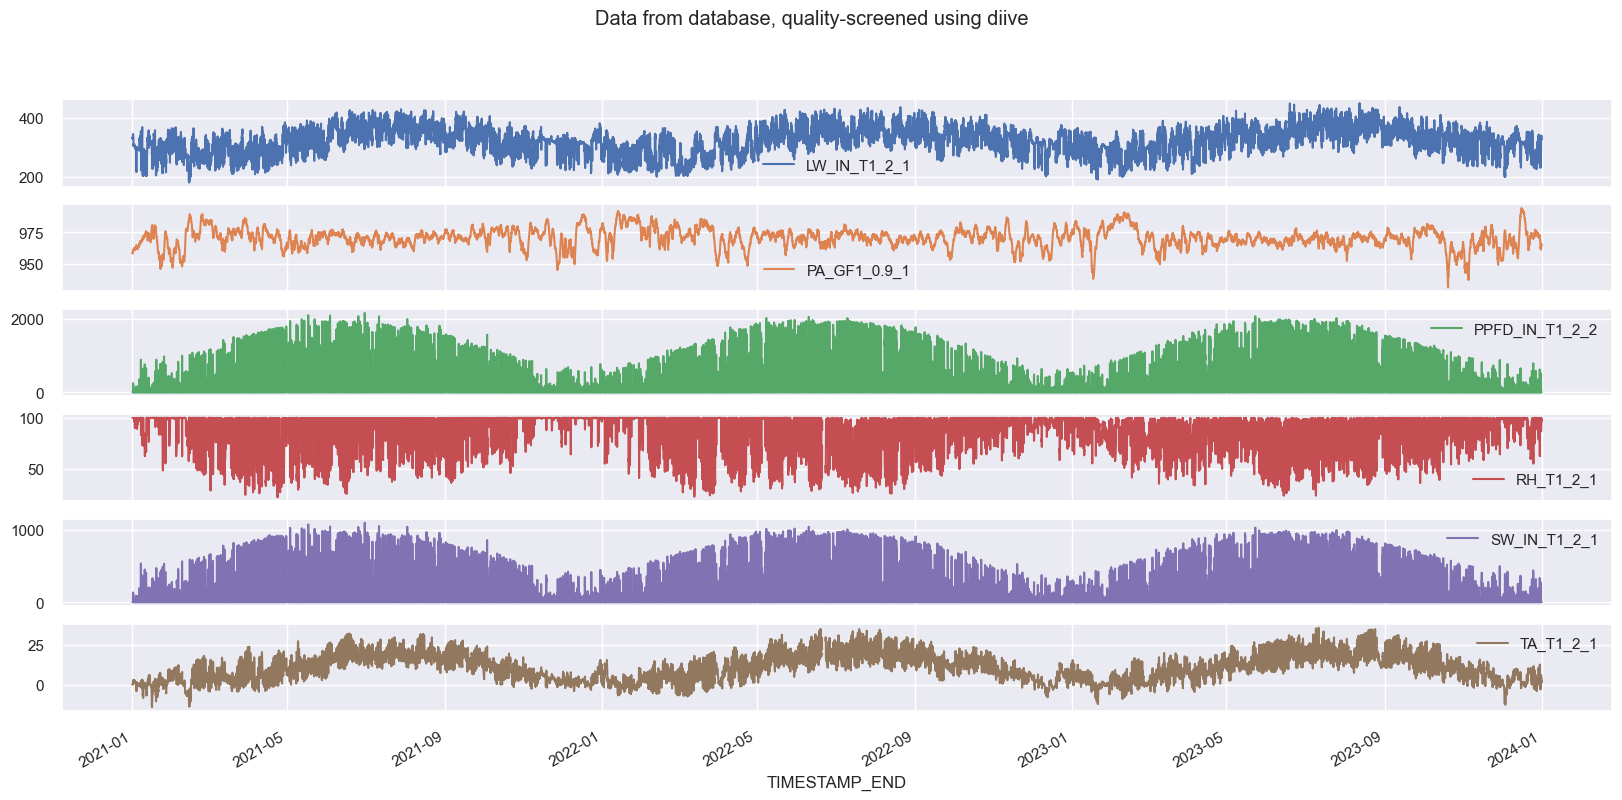

In [19]:
data_simple.plot(subplots=True, x_compat=True, title="Data from database, quality-screened using diive", figsize=(20, 9));

</br>

# **SAVE TO FILE**

In [23]:
OUTNAME = "14.1_CH-CHA_DATABASE_meteo6_2021-2023"
OUTPATH = r"F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\10_METEO\13_merge_meteo_for_analyses_2005-2023"
filepath = save_parquet(filename=OUTNAME, data=data_simple, outpath=OUTPATH)
data_simple.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\10_METEO\13_merge_meteo_for_analyses_2005-2023\14.1_CH-CHA_DATABASE_meteo6_2021-2023.parquet (0.043 seconds).


</br>

## Heatmaps

In [ ]:
for col in data_simple_renamed_fw23.columns:
    series = data_simple_renamed_fw23[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6, 9)).show()

</br>

# **Stats**

In [ ]:
data_simple_renamed_fw23.describe()

</br>

# **End of notebook**.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

</br>